In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
pd.set_option('max_columns', 200)
plt.style.use('ggplot')

## Read Data

In [3]:
html = pd.read_csv('../data/4_final_webpage_metadata.csv')

In [113]:
html.head()

,entityid,yr_from_start,capture_yr,capture_m,file_path,file_exists,website_size_kb,careers,blog,login,contact,team,about,news,faq,call_to_action,testimonial,title,description,keywords,p_count,h_count,img_count,a_count,table_count,form_count,script_count,entityname,new_industrygroup,state,weburl,pb_companyid,startdate,lastVC,ownershipstatus,exit_date,has_exit,end_yr,start_yr,lifespan,publicity_score,tag_sum
0,100035,5.0,2001,9,data/html/100035/2001/09/index.html,1,1.793945,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,0,2023.0,1997.0,26.0,0.000000,4
1,100035,5.0,2002,1,data/html/100035/2002/01/index.html,1,1.791016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,0,2023.0,1997.0,26.0,0.000000,4
2,100035,5.5,2002,7,data/html/100035/2002/07/index.html,1,9.054688,1,0,0,1,0,0,1,0,0,0,1,1,1,6,0,23,23,7,0,3,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,0,2023.0,1997.0,26.0,0.333333,62
3,100035,6.0,2002,9,data/html/100035/2002/09/index.html,1,9.054688,1,0,0,1,0,0,1,0,0,0,1,1,1,6,0,23,23,7,0,3,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,0,2023.0,1997.0,26.0,0.333333,62
4,100035,15.5,2012,8,data/html/100035/2012/08/index.html,1,0.032227,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,0,2023.0,1997.0,26.0,0.333333,0


## Publicity Score (For companies with lifespan <= 7 years)

In [7]:
pub_cols = ['careers', 'blog', 'login', 'contact',
       'team', 'about', 'news', 'faq', 'call_to_action', 'testimonial']
html["publicity_score"] = (html[pub_cols].sum(axis=1) / 9)

In [8]:
html.groupby("new_industrygroup")["publicity_score"].mean()

new_industrygroup
Business and Financial Services    0.495155
Consumer Goods                     0.472075
Consumer Services                  0.468529
Energy and Utilities               0.406573
Healthcare                         0.404425
Industrial Goods and Materials     0.401411
Information Technology             0.454916
To Be Assigned                     0.221435
Name: publicity_score, dtype: float64

In [9]:
html.dropna(subset=['new_industrygroup'], inplace=True)

**Regression on mean `publicity_score` (controlling for start year)**

In [48]:
reg_7 = html[html.lifespan <= 7] # Select only companies that have a lifespan of less than 7
r7_grp = reg_7.groupby('entityid')
X = pd.DataFrame({'Publicity Score': r7_grp.publicity_score.mean(), 'Start Year': r7_grp.start_yr.first()}) # Control for start year
X = sm.add_constant(X)
model = sm.OLS(r7_grp.has_exit.first(), X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               has_exit   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                 2.416e+04
Date:                Fri, 07 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:38:05   Log-Likelihood:                -3263.6
No. Observations:               31766   AIC:                             6533.
Df Residuals:                   31763   BIC:                             6558.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             113.9195      0.519    2

In [53]:
industry_dummies = pd.get_dummies(r7_grp.new_industrygroup.first(), drop_first=True)
X = pd.concat([r7_grp.publicity_score.mean(), industry_dummies], axis=1)
X = sm.add_constant(X)
model = sm.OLS(r7_grp.has_exit.first(), X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               has_exit   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     113.2
Date:                Fri, 07 Jul 2023   Prob (F-statistic):          2.06e-187
Time:                        15:56:56   Log-Likelihood:                -17504.
No. Observations:               31766   AIC:                         3.503e+04
Df Residuals:                   31757   BIC:                         3.510e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

**Plot controlling for industry**

In [10]:
# What are we controlling for?
# Lifespan within 7 years
# Startdate of 2017
s7 = html[(html.lifespan <= 7) & (html.ownershipstatus.isin(["Acquired/Merged", "Publicly-held"])) & (html.start_yr == 2016.0)] # Public of Acquired (successes)
f7 = html[(html.lifespan <= 7) & (html.ownershipstatus == "Private & Independent") & (html.start_yr == 2016.0)] # Still private (potential failures)

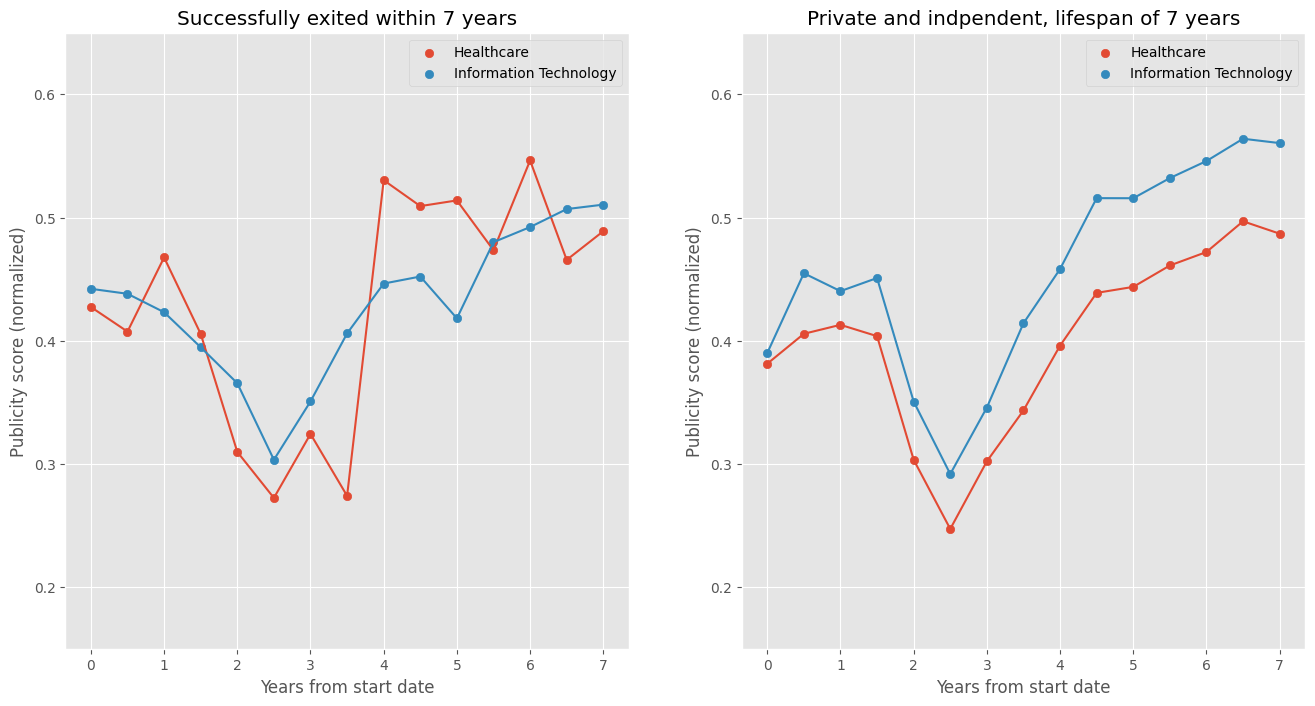

In [11]:
reg_7 = html[html.lifespan <= 7] # Select only companies that have a lifespan of less than 7
X = pd.DataFrame({'Publicity Score': reg_7.publicity_score, 'Start Year': reg_7.start_yr}) # Control for start year
X = sm.add_constant(X)
model = sm.OLS(reg_7.has_exit, X)
results = model.fit()
print(results.summary())fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
industries = ["Healthcare", "Information Technology"]
for x in industries:
    sdata = s7[s7.new_industrygroup == x].groupby('yr_from_start')['publicity_score'].mean()[0:7]
    ax1.scatter(sdata.index, sdata, label=x)
    ax1.plot(sdata.index, sdata)
    
    fdata = f7[f7.new_industrygroup == x].groupby('yr_from_start')['publicity_score'].mean()[0:7]
    ax2.scatter(fdata.index, fdata, label=x)
    ax2.plot(fdata.index, fdata)

    
ax1.set_xlabel("Years from start date")
ax2.set_xlabel("Years from start date")
    
ax1.set_ylabel("Publicity score (normalized)")
ax2.set_ylabel("Publicity score (normalized)")
    
ax1.set_title("Successfully exited within 7 years")
ax2.set_title("Private and indpendent, lifespan of 7 years")
    
ax1.set_ylim([0.15, 0.65])
ax2.set_ylim([0.15, 0.65])
    
ax1.legend()
ax2.legend()
plt.show()

## Growth in tag counts from year 0-3

In [57]:
tag_cols = ['p_count', 'h_count', 'img_count',
       'a_count', 'table_count', 'form_count', 'script_count']

In [80]:
html['tag_sum'] = html[tag_cols].sum(axis=1)

In [106]:
srange = pd.Series([-0.5, 0, 1])
erange = pd.Series([2.5, 3, 3.5])
# Create growth metrics
zeroThree_grp = html.groupby('entityid').filter(lambda x: ~srange[srange.isin(x['yr_from_start'].values)].empty and ~erange[erange.isin(x['yr_from_start'].values)].empty and 0 not in x['tag_sum'].values)




In [107]:
zeroThree_grp

,entityid,yr_from_start,capture_yr,capture_m,file_path,file_exists,website_size_kb,careers,blog,login,contact,team,about,news,faq,call_to_action,testimonial,title,description,keywords,p_count,h_count,img_count,a_count,table_count,form_count,script_count,entityname,new_industrygroup,state,weburl,pb_companyid,startdate,lastVC,ownershipstatus,exit_date,has_exit,end_yr,start_yr,lifespan,publicity_score,tag_sum
11,100065,2.0,1998,12,data/html/100065/1998/12/index.html,1,8.354492,0,0,1,1,0,1,1,0,0,0,1,0,0,5,0,11,9,5,0,4,TetraData,Information Technology,SC,www.tetradata.com,NaN,1997-01-01,2006-08-25,Acquired/Merged,2006-08-25,1,2006.0,1997.0,9.0,0.444444,34
12,100065,2.0,1999,2,data/html/100065/1999/02/index.html,1,8.355469,0,0,1,1,0,1,1,0,0,0,1,0,0,5,0,11,9,5,0,4,TetraData,Information Technology,SC,www.tetradata.com,NaN,1997-01-01,2006-08-25,Acquired/Merged,2006-08-25,1,2006.0,1997.0,9.0,0.444444,34
13,100065,2.0,1999,1,data/html/100065/1999/01/index.html,1,8.315430,0,0,1,1,0,1,1,0,0,0,1,0,0,5,0,11,9,5,0,4,TetraData,Information Technology,SC,www.tetradata.com,NaN,1997-01-01,2006-08-25,Acquired/Merged,2006-08-25,1,2006.0,1997.0,9.0,0.444444,34
14,100065,3.5,2000,7,data/html/100065/2000/07/index.html,1,4.822266,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,8,6,1,0,4,TetraData,Information Technology,SC,www.tetradata.com,NaN,1997-01-01,2006-08-25,Acquired/Merged,2006-08-25,1,2006.0,1997.0,9.0,0.333333,19
15,100065,4.0,2000,10,data/html/100065/2000/10/index.html,1,4.835938,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,8,6,1,0,4,TetraData,Information Technology,SC,www.tetradata.com,NaN,1997-01-01,2006-08-25,Acquired/Merged,2006-08-25,1,2006.0,1997.0,9.0,0.333333,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830492,728936,0.0,2021,9,data/html/728936/2021/09/index.html,1,609.729492,0,0,0,1,0,1,1,0,1,0,1,1,0,45,16,16,51,0,1,51,Truthset Inc.,Information Technology,CA,www.truthset.io,338510-53,NaN,2022-03-22,Private & Independent,NaN,0,2023.0,2022.0,1.0,0.444444,180
830493,728936,0.0,2022,2,data/html/728936/2022/02/index.html,1,651.221680,0,0,0,1,0,1,1,0,1,0,1,1,0,45,12,17,54,0,1,52,Truthset Inc.,Information Technology,CA,www.truthset.io,338510-53,NaN,2022-03-22,Private & Independent,NaN,0,2023.0,2022.0,1.0,0.444444,181
830494,728936,1.0,2022,9,data/html/728936/2022/09/index.html,1,570.644531,0,0,0,1,0,1,1,0,1,0,1,1,0,38,16,8,49,0,1,49,Truthset Inc.,Information Technology,CA,www.truthset.io,338510-53,NaN,2022-03-22,Private & Independent,NaN,0,2023.0,2022.0,1.0,0.444444,161
830495,728936,1.5,2023,5,data/html/728936/2023/05/index.html,1,596.093750,0,0,0,1,0,1,1,0,1,0,1,1,0,37,17,9,50,0,1,46,Truthset Inc.,Information Technology,CA,www.truthset.io,338510-53,NaN,2022-03-22,Private & Independent,NaN,0,2023.0,2022.0,1.0,0.444444,160


In [114]:
second_grp = zeroThree_grp.groupby('entityid')
tag_growth_rates = (second_grp.last().tag_sum - second_grp.first().tag_sum) / (second_grp.first().tag_sum)

entityid
53131          0.197917
53138         32.666667
53139          0.125000
53142          8.636364
53147          8.111111
                ...    
1052271254     0.000000
1052272415     0.350000
1052276600     0.000000
1052277716    48.000000
1052278175    -0.028369
Name: tag_sum, Length: 61821, dtype: float64

In [117]:
tag_growth_rates.iloc[53131]

1.46875

In [ ]:
html

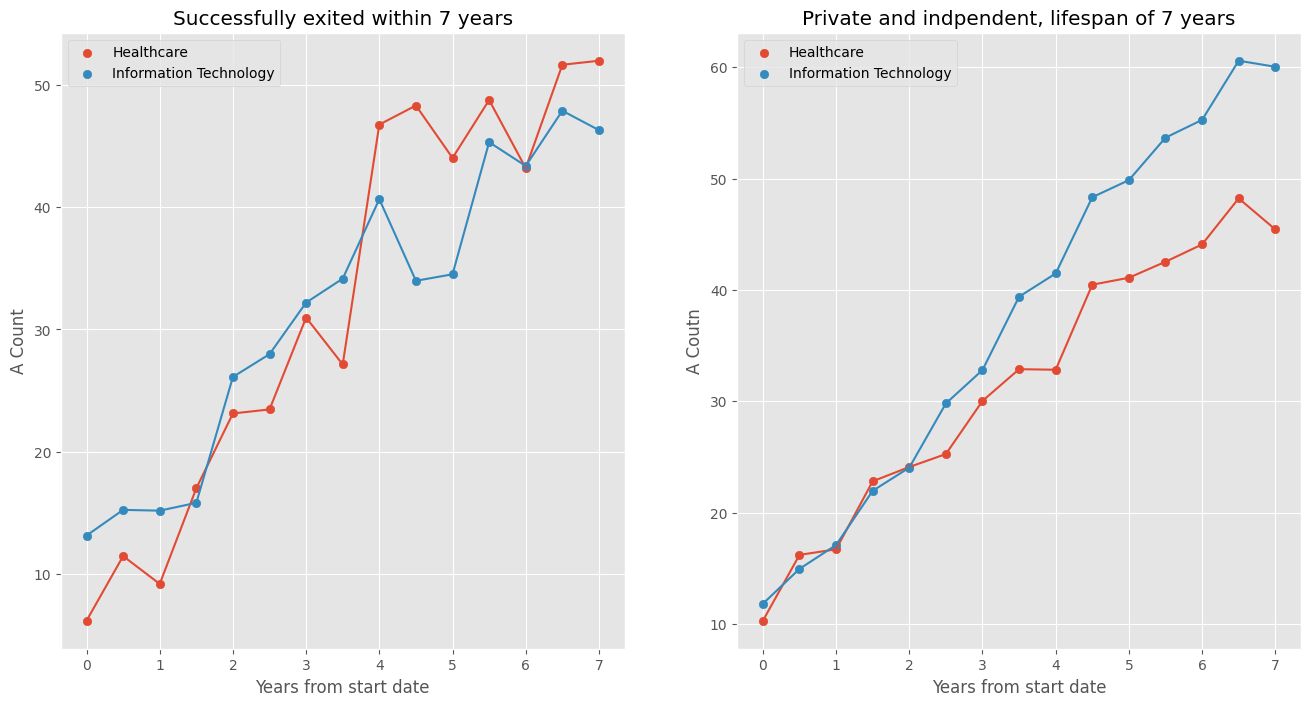

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
industries = ["Healthcare", "Information Technology"]
for x in industries:
    sdata = s7[s7.new_industrygroup == x].groupby('yr_from_start')['a_count'].mean()[0:7]
    ax1.scatter(sdata.index, sdata, label=x)
    ax1.plot(sdata.index, sdata)
    
    fdata = f7[f7.new_industrygroup == x].groupby('yr_from_start')['a_count'].mean()[0:7]
    ax2.scatter(fdata.index, fdata, label=x)
    ax2.plot(fdata.index, fdata)

    
ax1.set_xlabel("Years from start date")
ax2.set_xlabel("Years from start date")
    
ax1.set_ylabel("A Count")
ax2.set_ylabel("A Coutn")
    
ax1.set_title("Successfully exited within 7 years")
ax2.set_title("Private and indpendent, lifespan of 7 years")
    
# ax1.set_ylim([0.15, 0.65])
# ax2.set_ylim([0.15, 0.65])
    
ax1.legend()
ax2.legend()
plt.show()

## Growth in website size